# Sentiment Analisys ITA

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import transformers as ppb 
import matplotlib.pyplot as plt
from tensorflow import keras

### Import Dataset

In [2]:
df = pd.read_csv('data/betsentiment-IT-tweets-sentiment-players.csv', delimiter=',')

In [3]:
df.head()

,tweet_date_created,tweet_id,tweet_text,language,sentiment,sentiment_score
0,2018-12-10T10:45:40.865000,1072079899224100865,"@juventusfc @G_Higuain Auguri pipita,sempre co...",it,NEUTRAL,"{""Neutral"":0.858726024627685546875,""Negative"":..."
1,2018-06-30T18:41:02.817000,1013130303454498817,@realvarriale @massimozampini @KMbappe @G_Higu...,it,NEUTRAL,"{""Neutral"":0.973993778228759765625,""Negative"":..."
2,2018-12-26T19:40:44.308000,1078012758069858308,@OfficialASRoma @D_10Perotti @Hyundai_Italia S...,it,NEUTRAL,"{""Neutral"":0.9844334125518798828125,""Negative""..."
3,2018-07-12T11:26:37.766000,1017369635816181766,@CarloRienzi @Cristiano @juventusfc Populismo ...,it,NEUTRAL,"{""Neutral"":0.993849217891693115234375,""Negativ..."
4,2018-06-12T19:20:36,1006617282779451392,@OfficialASRoma @OfficialRadja @leonsfdo non c...,it,NEUTRAL,"{""Neutral"":0.87245881557464599609375,""Negative..."


In [4]:
df = df.iloc[:, [2,4]]

In [5]:
df.head()

,tweet_text,sentiment
0,"@juventusfc @G_Higuain Auguri pipita,sempre co...",NEUTRAL
1,@realvarriale @massimozampini @KMbappe @G_Higu...,NEUTRAL
2,@OfficialASRoma @D_10Perotti @Hyundai_Italia S...,NEUTRAL
3,@CarloRienzi @Cristiano @juventusfc Populismo ...,NEUTRAL
4,@OfficialASRoma @OfficialRadja @leonsfdo non c...,NEUTRAL


In [6]:
df.shape

(165815, 2)

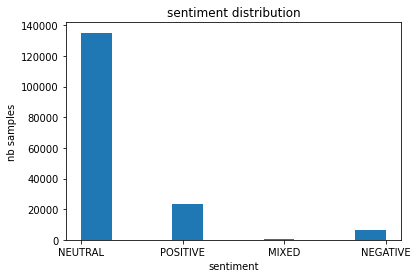

In [7]:
labels = df.loc[:,["sentiment"]]
plt.hist(labels)
plt.xlabel('sentiment')
plt.ylabel('nb samples')
plt.title('sentiment distribution')
plt.xticks(np.arange(len(np.unique(labels))));


In [8]:
for l in np.unique(labels):
    print (l, (labels.loc[labels['sentiment'] == l]).count()[0])




MIXED 527
NEGATIVE 6542
NEUTRAL 135194
POSITIVE 23552


In [9]:
df = df[df['sentiment'].isin(['POSITIVE', 'NEGATIVE'])]

In [10]:
df.shape

(30094, 2)

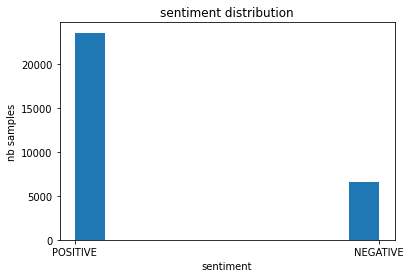

In [11]:
labels = df.loc[:,["sentiment"]]
plt.hist(labels)
plt.xlabel('sentiment')
plt.ylabel('nb samples')
plt.title('sentiment distribution')
plt.xticks(np.arange(len(np.unique(labels))));

In [12]:
df.loc[df['sentiment'] == 'POSITIVE', 'sentiment'] = 1
df.loc[df['sentiment'] == 'NEGATIVE', 'sentiment'] = 0

In [13]:
df = df[:6000]

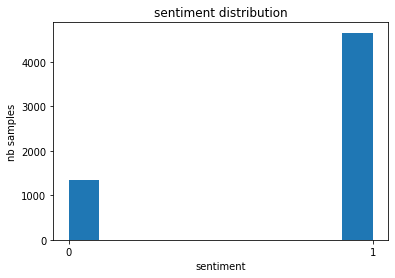

In [14]:
labels = df.loc[:,["sentiment"]]
plt.hist(labels)
plt.xlabel('sentiment')
plt.ylabel('nb samples')
plt.title('sentiment distribution')
plt.xticks(np.arange(len(np.unique(labels))));

### Loading the Pre-trained BERT model

In [15]:
# Italian Bert
model_class, tokenizer_class, pretrained_weights = (ppb.TFAutoModel, ppb.AutoTokenizer, 'dbmdz/bert-base-italian-xxl-cased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

Some layers from the model checkpoint at dbmdz/bert-base-italian-xxl-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at dbmdz/bert-base-italian-xxl-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


### Tokenization

In [16]:
def tokenize(sentences):
    tokenized = [tokenizer(sentence, add_special_tokens=True)['input_ids'] for sentence in sentences]
    return tokenized

In [17]:
tokenized = tokenize(df['tweet_text'])

In [18]:
print("sentence: ", df.iloc[0,0])
print("tokenized: ", tokenized[0])
print("decoded: ", tokenizer.decode(tokenized[0]))

sentence:  @LichtsteinerSte @juventusfc Grazie di tutto,#SwissExpress,sono stati 7 anni indimenticabili fatti di vittorie,sconfitte (poche!),enormi gioie e tante incazzature in campo con gli arbitri.? Sono stati 7 anni da #MY7H.
Mi mancherai.???
tokenized:  [102, 18969, 15776, 7281, 7723, 108, 25295, 18969, 30022, 399, 4505, 30896, 30885, 1141, 120, 564, 1307, 864, 25636, 13063, 12359, 1307, 288, 1030, 729, 578, 16821, 385, 3437, 120, 12008, 1307, 20133, 249, 6764, 2692, 4567, 1307, 12766, 8470, 30876, 126, 5974, 2617, 29219, 139, 1859, 153, 368, 12501, 303, 697, 3098, 694, 1030, 729, 578, 203, 864, 189, 30962, 30939, 30937, 697, 481, 23589, 3244, 697, 3098, 3098, 3098, 103]
decoded:  [CLS] @ LichtsteinerSte @ juventusfc Grazie di tutto, # SwissExpress, sono stati 7 anni indimenticabili fatti di vittorie, sconfitte ( poche! ), enormi gioie e tante incazzature in campo con gli arbitri.? Sono stati 7 anni da # MY7H. Mi mancherai.??? [SEP]


### Padding

In [19]:
def get_max_length(tokens):
    max_len = 0
    for i in tokens:
        if len(i) > max_len:
            max_len = len(i)
    return max_len

In [20]:
max_len = get_max_length(tokenized)
print("Max sentence legth is ", max_len)

Max sentence legth is  164


In [21]:
def pad_tokens(tokens, max_len):
    padded = np.array([i + [0]*(max_len-len(i)) for i in tokens])
    return padded

In [22]:
padded = pad_tokens(tokenized, max_len)

In [23]:
print(padded[0])

[  102 18969 15776  7281  7723   108 25295 18969 30022   399  4505 30896
 30885  1141   120   564  1307   864 25636 13063 12359  1307   288  1030
   729   578 16821   385  3437   120 12008  1307 20133   249  6764  2692
  4567  1307 12766  8470 30876   126  5974  2617 29219   139  1859   153
   368 12501   303   697  3098   694  1030   729   578   203   864   189
 30962 30939 30937   697   481 23589  3244   697  3098  3098  3098   103
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [24]:
print("shape of padded: ", padded.shape)

shape of padded:  (6000, 164)


### Masking

In [25]:
def get_attention_mask(tokens):
    attention_mask = np.where(tokens != 0, 1, 0)    
    return attention_mask

In [26]:
attention_mask = get_attention_mask(padded)
print(attention_mask[0])

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


### Create input tensors

In [27]:
input_ids = tf.convert_to_tensor(padded, dtype=tf.int32)
attention_mask = tf.convert_to_tensor(attention_mask, dtype=tf.int32)

The model() function runs our sentences through BERT. The results of the processing will be returned into last_hidden_states.

In [28]:
model.config.to_dict()['hidden_size']

768

In [30]:
batch_size = 100
m = input_ids.shape[0]
n = int(m / batch_size)

hidden_units =  model.config.to_dict()['hidden_size']
features = np.zeros((m, hidden_units))

print('Extract features using batches for memory issue:')

for i in range(n):
    j, k = i*batch_size, i*batch_size+batch_size
    print(f'Batch {i+1} [{j}:{k}]')
    batch_input = input_ids[j:k]
    batch_attention_mask = attention_mask[j:k]
    last_hidden_states = model(batch_input, attention_mask = batch_attention_mask)

    #Let's slice only the part of the output that we need. That is the output corresponding the first token of each sentence. 
    # The way BERT does sentence classification, is that it adds a token called [CLS] (for classification) at the beginning of 
    # every sentence. The output corresponding to that token can be thought of as an embedding for the entire sentence.
    features[j:k] = last_hidden_states[0][:,0,:].numpy()

    ## if you use BERT instead of distilBERT model, use this
    #features[j:k] = last_hidden_states[1].numpy() 

if(n*batch_size != m):
    i = i + 1
    j, k = i*batch_size, i*batch_size+(m-n*batch_size)
    print(f'Batch {i+1} [{j}:{k}]')
    batch_input = input_ids[j:k]
    batch_attention_mask = attention_mask[j:k]
    last_hidden_states = model(batch_input, attention_mask = batch_attention_mask)
    features[j:k] = last_hidden_states[0][:,0,:].numpy()


Extract features using batches for memory issue:
Batch 1 [0:100]
Batch 2 [100:200]
Batch 3 [200:300]
Batch 4 [300:400]
Batch 5 [400:500]
Batch 6 [500:600]
Batch 7 [600:700]
Batch 8 [700:800]
Batch 9 [800:900]
Batch 10 [900:1000]
Batch 11 [1000:1100]
Batch 12 [1100:1200]
Batch 13 [1200:1300]
Batch 14 [1300:1400]
Batch 15 [1400:1500]
Batch 16 [1500:1600]
Batch 17 [1600:1700]
Batch 18 [1700:1800]
Batch 19 [1800:1900]
Batch 20 [1900:2000]
Batch 21 [2000:2100]
Batch 22 [2100:2200]
Batch 23 [2200:2300]
Batch 24 [2300:2400]
Batch 25 [2400:2500]
Batch 26 [2500:2600]
Batch 27 [2600:2700]
Batch 28 [2700:2800]
Batch 29 [2800:2900]
Batch 30 [2900:3000]
Batch 31 [3000:3100]
Batch 32 [3100:3200]
Batch 33 [3200:3300]
Batch 34 [3300:3400]
Batch 35 [3400:3500]
Batch 36 [3500:3600]
Batch 37 [3600:3700]
Batch 38 [3700:3800]
Batch 39 [3800:3900]
Batch 40 [3900:4000]
Batch 41 [4000:4100]
Batch 42 [4100:4200]
Batch 43 [4200:4300]
Batch 44 [4300:4400]
Batch 45 [4400:4500]
Batch 46 [4500:4600]
Batch 47 [4600:

In [31]:
features.shape

(6000, 768)

In [48]:
lables = df['sentiment'].to_numpy(dtype="Int32")

In [49]:
# 80% train, 20% test
split_size = int(features.shape[0] * .8)    
X_train = features[:split_size,:]
Y_train = lables[:split_size]
X_test = features[split_size:,:]
Y_test = lables[split_size:]

print("shapes of training data: ", X_train.shape, Y_train.shape)
print("shapes of test data: ", X_test.shape, Y_test.shape)

shapes of training data:  (4800, 768) (4800,)
shapes of test data:  (1200, 768) (1200,)


### Create the Logistic Regression Model

In [50]:
def create_model(input_shape, classes):
    inputs = keras.Input(shape=input_shape, name='input')
    #h1 = keras.layers.Dense(1024, activation='relu', name='h1')(inputs)    
    #h2 = keras.layers.Dense(512, activation='relu', name='h2')(h1)
    #h3 = keras.layers.Dense(32, activation='relu', name='h3')(h2)
    d1 = keras.layers.Dropout(0.1, name='d1')(inputs)
    outputs = keras.layers.Dense(classes, activation='sigmoid', name='output')(d1)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    optimizer = tf.keras.optimizers.Adam()

    model.compile(
        loss='binary_crossentropy', 
        optimizer=optimizer, 
        metrics=['binary_accuracy']
    )

    return model

In [51]:
lr_model = create_model(X_train.shape[1], 1)
lr_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 768)]             0         
_________________________________________________________________
d1 (Dropout)                 (None, 768)               0         
_________________________________________________________________
output (Dense)               (None, 1)                 769       
Total params: 769
Trainable params: 769
Non-trainable params: 0
_________________________________________________________________


In [52]:
history = lr_model.fit(
    X_train,
    Y_train,
    epochs=100,
    batch_size=128,
    validation_split=0.2,
    verbose=1
)

Epoch 1/100
30/30 [==============================] - 1s 6ms/step - loss: 0.6143 - binary_accuracy: 0.7042 - val_loss: 0.5289 - val_binary_accuracy: 0.7760
Epoch 2/100
30/30 [==============================] - 0s 2ms/step - loss: 0.5050 - binary_accuracy: 0.7766 - val_loss: 0.5059 - val_binary_accuracy: 0.7771
Epoch 3/100
30/30 [==============================] - 0s 2ms/step - loss: 0.4845 - binary_accuracy: 0.7846 - val_loss: 0.4943 - val_binary_accuracy: 0.7802
Epoch 4/100
30/30 [==============================] - 0s 2ms/step - loss: 0.4698 - binary_accuracy: 0.7901 - val_loss: 0.4850 - val_binary_accuracy: 0.7844
Epoch 5/100
30/30 [==============================] - 0s 2ms/step - loss: 0.4574 - binary_accuracy: 0.7891 - val_loss: 0.4782 - val_binary_accuracy: 0.7844
Epoch 6/100
30/30 [==============================] - 0s 2ms/step - loss: 0.4497 - binary_accuracy: 0.7935 - val_loss: 0.4709 - val_binary_accuracy: 0.7885
Epoch 7/100
30/30 [==============================] - 0s 2ms/step - los

In [53]:
history_df = pd.DataFrame(history.history)
history_df['epoch'] = history.epoch
history_df.tail()

,loss,binary_accuracy,val_loss,val_binary_accuracy,epoch
95,0.325962,0.860156,0.358279,0.844792,95
96,0.320990,0.862760,0.357061,0.841667,96
97,0.318930,0.859896,0.357688,0.844792,97
98,0.323278,0.855469,0.358151,0.846875,98
99,0.316960,0.860937,0.357918,0.837500,99


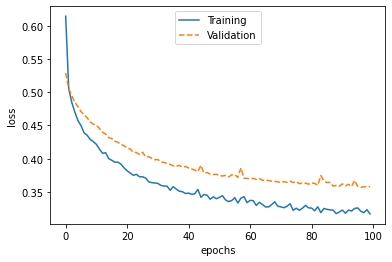

In [54]:
plt.xlabel('epochs')
plt.ylabel('loss')
#plt.ylim([0, 100])
plt.plot(history_df['epoch'], history_df['loss'], label='Training')
plt.plot(history_df['epoch'], history_df['val_loss'], label='Validation', linestyle='dashed')
plt.legend(loc='upper center', shadow=False)

### Model Evaluation

In [55]:
lr_model.evaluate(X_test, Y_test)

38/38 [==============================] - 0s 861us/step - loss: 0.3568 - binary_accuracy: 0.8333


[0.356804221868515, 0.8333333134651184]

### Inference

In [60]:
sentences = [
    "forza Fiorentina",
    "la Juventus è una squadra di merda",
    "oggi mi sono divertito molto", 
    "è un posto orrendo, non ci andrò mai più", 
    "oggi è una bellissima giornata"]

tokenized = tokenize(sentences)
padded = pad_tokens(tokenized, max_len)
attention_mask = get_attention_mask(padded)
attention_mask = tf.convert_to_tensor(attention_mask, dtype=tf.int32)
input_ids = tf.convert_to_tensor(padded, dtype=tf.int32)

last_hidden_states = model(input_ids, attention_mask = attention_mask)

features = last_hidden_states[0][:,0,:].numpy()
predictions = lr_model.predict(features) > .5

for i in range(len(sentences)):
    print(f'{sentences[i]}: {int(predictions[i][0])}')

forza Fiorentina: 1
la Juventus è una squadra di merda: 0
oggi mi sono divertito molto: 1
è un posto orrendo, non ci andrò mai più: 0
oggi è una bellissima giornata: 1
